# Loading

> Utilities to load Soil Spectral Libraries (SSL) compiled by [OSSL](https://soilspectroscopy.github.io/ossl-manual/) and others.

In [ ]:
# | default_exp loading

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
# | export
from pathlib import Path
from tqdm import tqdm
from typing import Union, List
import re
import itertools
import fastdownload as fd
import fastcore.all as fc

import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

import warnings
warnings.filterwarnings('ignore')

In [ ]:
from lssm.visualization import plot_spectra

## Large spectral libraries

KSSL, LUCAS, ... larger spectral library are now accessible through a single API endpoint provided by OSSL.

In [ ]:
# | export
PATH_OSSL_ALL_L0_V1_2 = 'https://storage.googleapis.com/soilspec4gg-public/ossl_all_L0_v1.2.csv.gz'
PATH_OSSL_ALL_L1_V1_2 = 'https://storage.googleapis.com/soilspec4gg-public/ossl_all_L0_v1.2.csv.gz'

CFGS = {
    'visnir': {'ref_col': 'scan_visnir.1500_ref', 'range': [400, 2500]},
    'mir': {'ref_col': 'scan_mir.1500_abs', 'range': [600, 4000]}
}

In [ ]:
# | export
def download(url: str,  # url to dowload data from
             dest_dir: str,  # directory to download data to
             ) -> None:
    "Download data available at `url` into the `dest` directory (creates it on the way if does not exist)."
    if not dest_dir.exists():
        fc.mkdir(dest_dir, parents=True)
    return fd.download_url(url, dest_dir)

In [ ]:
# | export
def load_ossl(analytes: Union[str, List[str]],  # Using OSSL's analytes naming conventions
              spectra_type: str = 'visnir',  # Possible values: 'mir', 'visnir'
              src: Path = Path.home() / '.lssm/data/ossl',  # directory containing the data
              debug:bool=False # return unprocessed loaded data directly for further investigation
              ):
    "Load all available OSSL data and filter it by spectra type and analytes of interest"

    url = PATH_OSSL_ALL_L1_V1_2
    fname = src / Path(PATH_OSSL_ALL_L1_V1_2).name
    if not fname.exists():
        print('Downloading & saving to: ', str(fname))
        download(url, src)

    print('Reading & selecting data ...')

    df = pd.read_csv(fname, compression='infer', low_memory=True)
    
    if debug: return df
    
    analytes = [analytes] if isinstance(analytes, str) else analytes

    subset = analytes + [CFGS[spectra_type]['ref_col']]
    df = df.dropna(subset=subset, how='any')

    cols_ref = [name for name in df.columns if f'scan_{spectra_type}.' in name]
    X = df[cols_ref].values

    y = df[analytes].values
    smp_idx = df['id.layer_uuid_txt'].values

    ds_name_encoder = LabelEncoder()
    ds_name = ds_name_encoder.fit_transform(df['dataset.code_ascii_txt'])

    pattern = r"scan_{}\.(\d+)_".format(spectra_type)
    X_names = np.array([int(re.search(pattern, name).group(1)) for name in df.columns
                        if re.search(pattern, name)])

    lower_limit, upper_limit = CFGS[spectra_type]['range']
    idxs = np.where((X_names >= lower_limit) & (X_names <= upper_limit))[0]

    return X[:, idxs], y, X_names[idxs], smp_idx, ds_name, ds_name_encoder.classes_


Example with Near-infrared data:

In [ ]:
# |eval: false
analytes = 'k.ext_usda.a725_cmolc.kg'
data = load_ossl(analytes, spectra_type='visnir')
X, y, X_names, smp_idx, ds_name, ds_label = data

print(X.shape, y.shape)

Reading & selecting data ...
(44489, 1051) (44489, 1)


Or with Mid-infrared ones:

In [ ]:
# |eval: false
analytes = 'k.ext_usda.a725_cmolc.kg'
data = load_ossl(analytes, spectra_type='mir')
X, y, X_names, smp_idx, ds_name, ds_label = data


Reading & selecting data ...


In [ ]:
# |eval: false
_, counts = np.unique(ds_name, return_counts=True)

# Number of data points per data provider:
list(zip(ds_label, counts))


[('GARRETT.SSL', 183),
 ('ICRAF.ISRIC', 3672),
 ('KSSL.SSL', 53230),
 ('LUCAS.WOODWELL.SSL', 589)]

## OSSL MIR ring trial data

In [ ]:
# | export
def load_mir_ring_trial(fname): return pd.read_csv(fname)

Example:

In [ ]:
# |eval: false
fname = Path().home() / \
    'pro/data/woodwell-ringtrial/drive-download-20231013T123706Z-001/RT_STD_allMIRspectra_raw.csv'
df = load_mir_ring_trial(fname)
df.head()


,organization,sample_id,650,652,654,656,658,660,662,664,...,3982,3984,3986,3988,3990,3992,3994,3996,3998,4000
0,Agrocares,RT_01,1.97644,1.97292,1.97015,1.96778,1.96656,1.96609,1.96656,1.96773,...,1.09917,1.09898,1.09877,1.09851,1.09827,1.09811,1.09797,1.09797,1.09797,1.09797
1,Agrocares,RT_02,2.48977,2.50440,2.51282,2.51789,2.51765,2.51403,2.50914,2.50330,...,1.24065,1.24042,1.24015,1.23977,1.23938,1.23896,1.23861,1.23861,1.23861,1.23861
2,Agrocares,RT_03,2.63074,2.63082,2.63692,2.64624,2.64827,2.64566,2.63292,2.61260,...,1.25036,1.24959,1.24877,1.24777,1.24679,1.24585,1.24505,1.24505,1.24505,1.24505
3,Agrocares,RT_04,2.27312,2.26257,2.25124,2.23949,2.23315,2.23026,2.22792,2.22598,...,1.15192,1.15176,1.15158,1.15132,1.15106,1.15080,1.15058,1.15058,1.15058,1.15058
4,Agrocares,RT_05,2.26744,2.25584,2.24658,2.23859,2.23159,2.22521,2.22157,2.22000,...,1.16109,1.16106,1.16102,1.16095,1.16086,1.16070,1.16056,1.16056,1.16056,1.16056


In [ ]:
# | export
def get_spectra_pair_idxs(df):
    """
    Retrieve index pairs of replicated spectra, representing measurements taken from the same soil sample
    but using different instruments.
    """
    pair_idxs = []
    for smp_id in df.sample_id.unique():
        indices = df[df.sample_id == smp_id].index
        pair_idxs.extend(list(itertools.product(indices, repeat=2)))
    return pair_idxs


Example:

In [ ]:
df_test = pd.DataFrame({'sample_id': [0,0,1,1]}, index= [0,1,2,3]); df_test

,sample_id
0,0
1,0
2,1
3,1


In [ ]:
expected = [(0, 0), (0, 1), (1, 0), (1, 1), (2, 2), (2, 3), (3, 2), (3, 3)]
fc.test_eq(get_spectra_pair_idxs(df_test), expected)

## MIR & NIR Kex spiking experiment

In [ ]:
# | export
def load_mir_kex_spike(src_dir):
    """
    Load MIR spectra of K spiked soil samples.
    
    Parameters:
    src_dir (Path-like object): Directory containing the spectra files.
    
    Returns:
    tuple: Tuple containing the array of absorbance values, 
           array of wavenumbers (columns), and array of sample names (rows).
    """
    pattern = r'-\d-\d$'
    fnames = [f for f in src_dir.ls() if re.search(pattern, f.stem)]
    
    dfs = [pd.read_csv(fname, header=None, names=['wavenumber', 'absorbance'])
           .query('649 < wavenumber < 4000')
           .assign(name=fname.stem) for fname in fnames]
    
    df_combined = pd.concat(dfs).pivot_table(values='absorbance', index='name', columns='wavenumber')
    
    return df_combined.values, df_combined.columns.values, df_combined.index.values.astype('U')


In [ ]:
# def load_mir_kex_spike(src_dir): 
#     "Load MIR spectra of K spiked soil samples"
#     pattern = r'-\d-\d$'
#     fnames = [f for f in src_dir.ls() if re.search(pattern, f.stem)]
#     dfs = []
#     for fname in fnames:
#         df = pd.read_csv(fname, header=None, names=['wavenumber', 'absorbance'])
#         df = df[(df.wavenumber > 649) & (df.wavenumber < 4000)]
#         df['name'] = fname.stem
#         dfs.append(df)
#     df = pd.concat(dfs).pivot_table(values='absorbance', index='name', columns='wavenumber')
#     return df.values, df_mir_spiked.columns.values, df_mir_spiked.index.values.astype('U')

For example:

In [ ]:
# |eval: false
src_dir = Path().home() / 'pro/data/k-spiking/mir'
X, wavenumbers, names = load_mir_kex_spike(src_dir)

<Figure size 640x480 with 0 Axes>

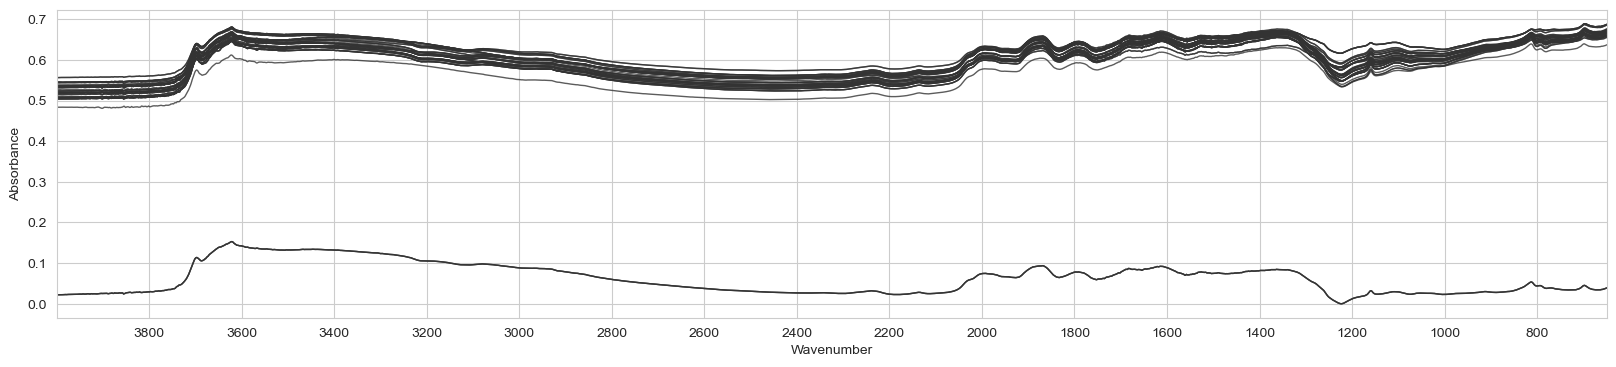

In [ ]:
# |eval: false
mask_smp = np.char.find(names, 'TM') == 0
plot_spectra(X[mask_smp,:], wavenumbers, ascending=False)

In [ ]:
# | export
def load_nir_kex_spike(fname):
    """
    Load NIR spectra of K spiked soil samples.
    
    Parameters:
    fname (str or Path-like object): File name or path of the Excel file.
    
    Returns:
    tuple: Tuple containing the array of spectral values, 
           array of wavenumbers (columns), and array of sample names (rows).
    """
    df = pd.read_excel(fname, sheet_name='Results', index_col='Sample ID')
    df.index.name = 'name'
    df.columns.name = 'wavenumber'
    
    return df.values, df.columns.values, df.index.values.astype('U')

In [ ]:
# |eval: false
fname = Path().home() / 'pro/data/k-spiking/nir/2023-12-8 _FT-NIR-K-spiked soil.xlsx'
X, wavenumbers, names = load_nir_kex_spike(fname)

<Figure size 640x480 with 0 Axes>

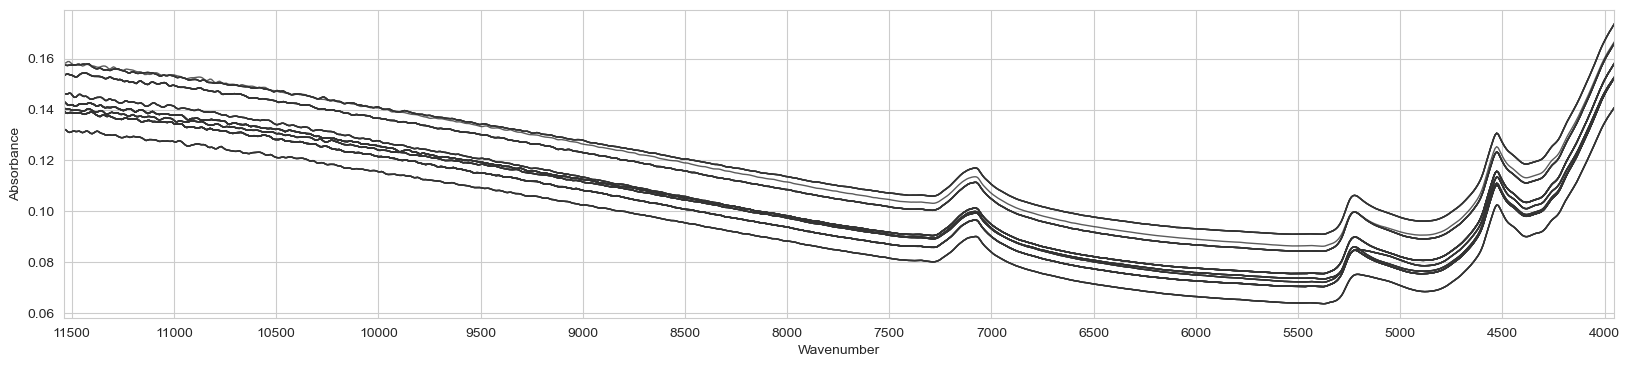

In [ ]:
mask_smp = np.char.find(names, 'TM') == 0
plot_spectra(X[mask_smp,:], wavenumbers, ascending=False)

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()